# Core concepts

Below I define few critical concepts for Orcapod.

* `Data` -- In Orcapod, smallest unit of `data` is a single `file`. Unlike many other computation pipeline system, Orcapod pipeline in principle does **not** operate on `data` that's not a file. In other words, `Oracpod` pipeline will **not** pass a data in memory from one node to another. Consequently, all operations and processing in Orcapod pipeline revolves around `file` (NOTE: this is a particularly strong/restrictive version of Oracpod pipeline. We may consider extending data to things like environment variable and command line arguments)
* `Pathset` -- a unit of data that can be passed into a pod. A `pathset` consists of a file, a directory, or a collection of one or more file and directories.
* `Packet` -- a single concrete instance of key-value pair, mapping packet key to a single `pathset`.
* `Stream` -- a series of one or more `packets` flowing from a `data producer` to a `data consumer`. In a directed acyclic graph represneing an Orcapod `pipeline`, a `stream` corresponds to a *directed* edge connecting from a data source into a `data consumer` (e.g., `pod`)
* `Data producer` and `data consumer` -- in the Orcapod data pipeline, data (in form of `packet` of data flowing inside a `stream`) flows from a `data producer` to a `data consumer`. Consequentially, a `data consumer` may in turn act as a `data producer` downstream
* `Data source` -- Root level `data producer` (that is, the data originates from this `data producer` and it is not a `data consumer` of any stream). Typically `data source` is tied to a data storage, although you could have *procedural* `data source` where data packets are produced programatically.
* `Tag` -- each `Packet` in a stream *may be* associated with a `tag` that helps to assign semantic identity to the particular `packet`. For example, a data `packet` for an experimental data may be associated with a `tag` of session ID. Note that while `tag` provides a convenient and often meaningful ways of identifying and referring to specific packet within a stream, it should **not** be considered to be the defining identity of the `packet`. Identity of the `packet` is strictly determined by the exact data content of the `packet`, and not by how you refer to it. Consequently, it may be that two packets with an identical content (and thus shared identity) are associated with distinct `tags` in a `stream`. Conversely, an identical `tag` may be associated with two distinct `packets` in a stream.  Typically, one would associate a unique `tag` for each packet in the stream.
* `Operation` -- A *node* in the directed acyclic graph representing an Orcapod `pipeline`, corresponding to a step of data processing/transformation/computation. An `Operation` receives can be classified into either a `mapper` or a `pod` based on their role in `data provenance`.
* `Mapper` -- A class of `operation` that does **not** result in creation/alteration of a new data -- that is, `operation` does **not** every create or modify a file *content*. More specifically, `Mapper` operation can not produce a path that was not already present in the input streams to the `mapper`. This feature ensures that a `mapper` is fundamentally not involved in the reproducibility of computation. Consequently, `mapper` information is not necessary for the maintenance of proper `data provenance` in a tree of computation. However, `mapper` plays critical role in the actual execution of a data pipeline, determining which data `packet` will be fed into operations in the pipeline directed acyclic graph (DAG). Note that as long as it doesn't modify the content of any file, a `mapper` may inspect the content of any file in a `packet` it receives and alter its behavior based on the content of the file. In other words, `mapper` may alter what data file(s) gets passed around without changing/creating any file based on a rule that depends on `tag`, `packet` key (`argument` name) and/or file content.
* `Pod` (e.g. FunctionPod) -- fundamental unit of computation in Orcapod. `Pod` is the only class of `operation` that may create a new file. Critically, when operating within an Orcapod `pipeline`, a `pod` will **not** receive the `tag` information. Rather, `pod` must strictly operate on a single `packet`. An ideal `pod` will have completely deterministic behavior that only depends on the `packet` identity (that is, packet keys and `pathset` contents).

# What is Orcabrdige?

`Orcabridge` provide prototypal implementation of the above-defined key concepts in `orcapod`, with particular focus given to `stream`, `packet`, `tag`, `operation` (`pod` and `mapper`). This package provides the reference implementation of both synchronous and asynchronous `streams` as a sequence of `packets` associated with a `tag`. 

### Key limitations
Being a very basic reference implementation with a goal of serving as a playground for conceptual and algorithmic development, there are a few notable limitations in `orcabridge`, lacking some important features that would be found in the full implementation of `orcapod`.

* Limited `pathset` -- Only a very rudimentary implementation of a `pathset` can be found, where a typical `packet` would be a simple key-value pair where the value is a single file path. 
* `FunctionPod` in place of `pod` -- A ideal `pod` will represent a completely reproducible unit of computation with strict dependence on the input `packet` to the `pod`. However, in `orcabridge` is equivalated to a Python function -- even more specifically, the name assigned to the Python function. In otherwords, two `FunctionPods` are considered identical if they share the same function name. Quite obviously this is a gross simplification that can be trivially violated. However, for the intended purpose of `orcabridge`, this rather simplistic implementation/definition of `pod` should suffice to test all features in the `pipeline`. Consequently, to ensure that the pipeline operates as expected, **do not use the same name for two distinct functions**. Doing so will break the fundamental assumption of `FunctionPod` and lead to completely erradic behavior. On the other hand, it is ok to have one or more name used to refer to an identical function.
* Different pipeline DAG defintion -- In `orcapod` the directed acyclic graph (DAG) for the `pipeline` should be defined using YAML file (or less frequently using API on `pipeline` struct in the Rust library). In `orcabridge` you will find that a `pipeline` DAG is defined dynamically through a series of application of `operation`. This is very much akin to how some DAG-based neural network library like TensorFlow defines a computation graph. While this works well for simple examples, it is rather difficult to track changes to the pipeline defined dynamically/programmatically using version control system. Since *how* you define the pipeline DAG is strictly speaking an orthogonal problem to the everything else that concerns the operation of the `pipeline`, no effort will be given to align the DAG definition in `orcabridge` and `orcapod`.
* Limited usage of a `stream` -- Currently `orcabrdige` only support single producer single consumer (SCSP) `stream`x, whereas in `orcapod`, `stream` should support single producer multiple consumer (SPMC) paradigm. While the same stream can be used in multiple downstream operations, each iteration of the stream actually results in recomputations of the entire chain of pipeline leading up to that stream. This inefficiency can be ameliorated by `CacheStream` operation after particularly computationally expensive segment of the pipeline. Using storage-backed `FunctionPod` will also help ameliorate the cost of recomputation by retrieving memoized computation result instead of recomputing.

# Using Orcabridge

Below we explore the usage of `orcabridge` package, enumerating the core components.

## Working with streams

`Stream` is fundamental to Orcapod datapipeline, representing *edges* in a directed acyclic graph (DAG) of an Orcapod pipeline. `Stream` is best thought of as a flowing stream of `packets` -- a unit of data in Oracpod. A `packet` is essentially a ditionary mapping argument names to a `pathset` (that is, one or more files with arbitrary nesting). Ultimately, a pod will receive and work on the `packet`, looking up the pathset that matches the expected argument names defined as the inputs into the pod. Before we explore creating and using `pod`, we will create a very basic `stream` called `GlobStream`, sourcing from a directory. A packet is formed for each file that matches the specified *glob* pattern.

In [1]:
from orcabridge.source import GlobSource

Let's create a data source out of all `*.txt` files found in the folder `examples/dataset1`

In [2]:
ls ./examples/dataset1

day1.txt*  day2.txt*  day3.txt*  day4.txt*


In [3]:
dataset1 = GlobSource('txt_file', './examples/dataset1', '*.txt')

We can then obtain `stream` from a `source` by invoking the source with `Source()`. The return `stream` acts as an iterator over the `packet` and its `tag`.
For convenience, `source` can also directly act as an iterator, equivalent to iterating over a stream returned by calling the source.

In [4]:
for tag, packet in dataset1():
    print(f'Packet {packet} with tag {tag}')

Packet {'txt_file': PosixPath('examples/dataset1/day1.txt')} with tag {'file_name': 'day1'}
Packet {'txt_file': PosixPath('examples/dataset1/day2.txt')} with tag {'file_name': 'day2'}
Packet {'txt_file': PosixPath('examples/dataset1/day3.txt')} with tag {'file_name': 'day3'}
Packet {'txt_file': PosixPath('examples/dataset1/day4.txt')} with tag {'file_name': 'day4'}


In [5]:
# equivalent to above but more natural without the need to call `dataset1()`
for tag, packet in dataset1:
    print(f'Packet {packet} with tag {tag}')

Packet {'txt_file': PosixPath('examples/dataset1/day1.txt')} with tag {'file_name': 'day1'}
Packet {'txt_file': PosixPath('examples/dataset1/day2.txt')} with tag {'file_name': 'day2'}
Packet {'txt_file': PosixPath('examples/dataset1/day3.txt')} with tag {'file_name': 'day3'}
Packet {'txt_file': PosixPath('examples/dataset1/day4.txt')} with tag {'file_name': 'day4'}


A few things to note. When creating the `GlobSource` we pass in the argument name to be associated with the `pathset` matching our glob pattern (`*.txt` in this case). By default, the `GlobSource` tags each packet with a key of `file_name` and value of the name of the file that was matched (minus the file extension). This behavior can be easily changed by passing in a custom function for tag generation at the time of `GlobSource` creation.

In [6]:
from pathlib import Path
dataset1_custom = GlobSource('data', './examples/dataset1', '*.txt', tag_function=lambda x: {'date': Path(x).stem})

In [7]:
for tag, packet in dataset1_custom:
    print(f'Packet {packet} with tag {tag}')

Packet {'data': PosixPath('examples/dataset1/day1.txt')} with tag {'date': 'day1'}
Packet {'data': PosixPath('examples/dataset1/day2.txt')} with tag {'date': 'day2'}
Packet {'data': PosixPath('examples/dataset1/day3.txt')} with tag {'date': 'day3'}
Packet {'data': PosixPath('examples/dataset1/day4.txt')} with tag {'date': 'day4'}


Custom tag function would allow one to extract information useful in controlling the flow of the data pipeline from the file path or even the file content. We will return to this a bit later.

In general, a packet is generated and starts flowing into a `stream` **only** when you ask for it by iterating through the elements. This allows for a series of streams and pods to be chained together without immediately invoking any computation.

Let's go ahead and load another source from a folder containing multiple `*.bin` files, representing data collected on different days.

In [8]:
dataset2 = GlobSource('bin_data', './examples/dataset2', '*.bin')

for tag, packet in dataset2:
    print(f'Packet {packet} with tag {tag}')

Packet {'bin_data': PosixPath('examples/dataset2/session_day1.bin')} with tag {'file_name': 'session_day1'}
Packet {'bin_data': PosixPath('examples/dataset2/session_day3.bin')} with tag {'file_name': 'session_day3'}
Packet {'bin_data': PosixPath('examples/dataset2/session_day4.bin')} with tag {'file_name': 'session_day4'}
Packet {'bin_data': PosixPath('examples/dataset2/session_day5.bin')} with tag {'file_name': 'session_day5'}


Now we have two streams to work with, let's explore how we can manipulate/control the flow of streams using `operations` and, specifically, `mapper` operations.

## Manipulating streams with `operations`

As defined ealier in the [core concepts](#core-concepts), we refer to any computation/transformation that works on stream(s) as `operations` in the pipeline. If the Orcapod pipeline were to be viewed as a DAG, the `streams` would be the edges connecting *nodes* that are the `operations`. 

`Operations` can be divided into two categories based on their roles in the processing and manipulating streams. `Mappers` are `operations` that controls and alter the streams but *without generating or modifying new data files*. As we will see shortly, `mappers` work to alter the stream by alterning packet tags and/or packet content, but critically will never create or modify new files that were not already present somewhere in the stream feeding into the `mapper` node. While this might sound like an unnecessary restriction on what `mappers` can do, we will see that this property guarantees that *mappers can not ever alter the reproducibility of computational chains*.

The second category of `operations` are called the `pods`, and as you may have guessed, these operations are **allowed to generate and flow new files into the streams**. In fact, `pods` are the only operations that can introduce new files into the stream. Consequently, stream `sources` such as `GlobFileSource` we saw earlier are also a type of pods, that's special in that it takes no input streams!

We will explore pods in great detail later. First let's get to know `mappers`.

### Controling data streams with `Mappers`

Once you have created `source` from which streams can be formed, you can alter the stream by applying various `mappers`. More precisely, a `mapper` can work on tags and/or packets.

### Map keys
Likey one of the most common mapper operation to be found in Orcapod pipeline is `MapKeys` mapper. As the name implies, it let's you alter the keys (argument names) found in the `packet`.

In [9]:
from orcabridge.mapper import MapKeys

print("Before mapping:")
for tag, packet in dataset1:
    print(f'Packet {packet} with tag {tag}')


# create a new stream mapping packet keys 'txt_file' to 'content'
key_mapper = MapKeys(key_map={'txt_file': 'content'})

print("After mapping:")
for tag, packet in key_mapper(dataset1):
    print(f'Mapped Packet {packet} with tag {tag}')


Before mapping:
Packet {'txt_file': PosixPath('examples/dataset1/day1.txt')} with tag {'file_name': 'day1'}
Packet {'txt_file': PosixPath('examples/dataset1/day2.txt')} with tag {'file_name': 'day2'}
Packet {'txt_file': PosixPath('examples/dataset1/day3.txt')} with tag {'file_name': 'day3'}
Packet {'txt_file': PosixPath('examples/dataset1/day4.txt')} with tag {'file_name': 'day4'}
After mapping:
Mapped Packet {'content': PosixPath('examples/dataset1/day1.txt')} with tag {'file_name': 'day1'}
Mapped Packet {'content': PosixPath('examples/dataset1/day2.txt')} with tag {'file_name': 'day2'}
Mapped Packet {'content': PosixPath('examples/dataset1/day3.txt')} with tag {'file_name': 'day3'}
Mapped Packet {'content': PosixPath('examples/dataset1/day4.txt')} with tag {'file_name': 'day4'}


You'd notice that for each packet, the key `txt_file` was replaced with `content` without altering the pointed `path` or the associated tag. As the keys of the packets will be used as the name of arguments when invoking pods on a stream, we will see that `MapKeys` are commonly used to *map* the correct path to the argument.

### Map tags
As we have already seen, each packet in the stream is associated with a tag, often derived from the data source. In the case of `GlobFileSource`, the tags are by default the name of the file that formed the packet. These tags are used to *transiently* identify the packet and will be used when matching packets across multiple streams (as we will see shortly in `Join` operation). You can manipulate the tags using `MapTags` operation, much like `MapKeys` but operating on the tags for each packaet under a uniform renaming rule.

In [10]:
from orcabridge.mapper import MapTags
tag_mapper = MapTags(tag_map={'file_name': 'day'})

for tag, packet in tag_mapper(dataset1):
    print(tag, packet)

{'day': 'day1'} {'txt_file': PosixPath('examples/dataset1/day1.txt')}
{'day': 'day2'} {'txt_file': PosixPath('examples/dataset1/day2.txt')}
{'day': 'day3'} {'txt_file': PosixPath('examples/dataset1/day3.txt')}
{'day': 'day4'} {'txt_file': PosixPath('examples/dataset1/day4.txt')}


### Chaining operations

As you might expect, you can chain multiple operations one after another to construct a more complex stream. Below, we first apply the key mapping and then map tags.

In [11]:
key_mapper = MapKeys(key_map={'txt_file': 'content'})
key_mapped_stream = key_mapper(dataset1)

tag_mapper = MapTags(tag_map={'file_name': 'day'})
tag_and_key_mapped = tag_mapper(key_mapped_stream)

for tag, packet in tag_and_key_mapped:
    print(f"Mapped Packet {packet} with tag {tag}")


Mapped Packet {'content': PosixPath('examples/dataset1/day1.txt')} with tag {'day': 'day1'}
Mapped Packet {'content': PosixPath('examples/dataset1/day2.txt')} with tag {'day': 'day2'}
Mapped Packet {'content': PosixPath('examples/dataset1/day3.txt')} with tag {'day': 'day3'}
Mapped Packet {'content': PosixPath('examples/dataset1/day4.txt')} with tag {'day': 'day4'}


It's worth emphasizing again that all computations are triggered only when you iterate through the final stream `tag_and_key_mapped`

Although not recommended as it reduces readability, you can create and immediately apply `mapper` to achieve the same processing in a fewer lines of code (albeit, with worse readability):

In [12]:
# totally valid, but difficult to read and thus not recommended
for tag, packet in MapTags(tag_map={'file_name': 'day'})(MapKeys(key_map={'txt_file': 'content'})(dataset1)):
    print(f"Mapped Packet {packet} with tag {tag}")

Mapped Packet {'content': PosixPath('examples/dataset1/day1.txt')} with tag {'day': 'day1'}
Mapped Packet {'content': PosixPath('examples/dataset1/day2.txt')} with tag {'day': 'day2'}
Mapped Packet {'content': PosixPath('examples/dataset1/day3.txt')} with tag {'day': 'day3'}
Mapped Packet {'content': PosixPath('examples/dataset1/day4.txt')} with tag {'day': 'day4'}


### Joining multiple streams into a single stream
Now that we have looked at how you can manipulate a single stream, let's turn our eyes to how you can work with more than one streams together.

By the far the most common multi-stream operations will be to join two (or more) streams into a single, bigger stream. 
You can combine multiple streams into one by using `Join` operation, matching packets from each stream based on the matching tags. If tags from two streams have shared key, the value must be identical for all shared keys for the two packets to be matched. The matched packets are then merged into a one (typically larger) packet and shipped to the output stream.

Let's see what happens if we join `dataset1` and `dataset2`, where:

In [13]:
# dataset 1
print("Dataset 1:")
for tag, packet in dataset1:
    print(f'Tag: {tag}, Packet: {packet}')

# dataset 2
print("\nDataset 2:")
for tag, packet in dataset2:
    print(f'Tag: {tag}, Packet: {packet}')



Dataset 1:
Tag: {'file_name': 'day1'}, Packet: {'txt_file': PosixPath('examples/dataset1/day1.txt')}
Tag: {'file_name': 'day2'}, Packet: {'txt_file': PosixPath('examples/dataset1/day2.txt')}
Tag: {'file_name': 'day3'}, Packet: {'txt_file': PosixPath('examples/dataset1/day3.txt')}
Tag: {'file_name': 'day4'}, Packet: {'txt_file': PosixPath('examples/dataset1/day4.txt')}

Dataset 2:
Tag: {'file_name': 'session_day1'}, Packet: {'bin_data': PosixPath('examples/dataset2/session_day1.bin')}
Tag: {'file_name': 'session_day3'}, Packet: {'bin_data': PosixPath('examples/dataset2/session_day3.bin')}
Tag: {'file_name': 'session_day4'}, Packet: {'bin_data': PosixPath('examples/dataset2/session_day4.bin')}
Tag: {'file_name': 'session_day5'}, Packet: {'bin_data': PosixPath('examples/dataset2/session_day5.bin')}


Any guess what would happen?

In [14]:
from orcabridge.mapper import Join
join_op = Join()

for tag, packet in join_op(dataset1, dataset2):
    print(f'Tag: {tag}, Packet: {packet}')

You may be surprised to see that the joined stream is completely empty! This is because packets from both streams were tagged with key `file_name`, causing the `Join` to combine packets only if the value of `file_name` matches exactly. Since no filenames matched, the resulting stream was empty!

This is where we can make use of the other `mappers` to our advantage and achieve more useful join.

First, let's completely rename the tag key for one of the streams and see what would happen.

In [15]:
dataset1_retagged = MapTags(tag_map={'file_name': 'day'})(dataset1)

for i, (tag, packet)in enumerate(join_op(dataset1_retagged, dataset2)):
    print(f'{i+1:02d} Tag: {tag}, Packet: {packet}')

01 Tag: {'day': 'day1', 'file_name': 'session_day1'}, Packet: {'txt_file': PosixPath('examples/dataset1/day1.txt'), 'bin_data': PosixPath('examples/dataset2/session_day1.bin')}
02 Tag: {'day': 'day1', 'file_name': 'session_day3'}, Packet: {'txt_file': PosixPath('examples/dataset1/day1.txt'), 'bin_data': PosixPath('examples/dataset2/session_day3.bin')}
03 Tag: {'day': 'day1', 'file_name': 'session_day4'}, Packet: {'txt_file': PosixPath('examples/dataset1/day1.txt'), 'bin_data': PosixPath('examples/dataset2/session_day4.bin')}
04 Tag: {'day': 'day1', 'file_name': 'session_day5'}, Packet: {'txt_file': PosixPath('examples/dataset1/day1.txt'), 'bin_data': PosixPath('examples/dataset2/session_day5.bin')}
05 Tag: {'day': 'day2', 'file_name': 'session_day1'}, Packet: {'txt_file': PosixPath('examples/dataset1/day2.txt'), 'bin_data': PosixPath('examples/dataset2/session_day1.bin')}
06 Tag: {'day': 'day2', 'file_name': 'session_day3'}, Packet: {'txt_file': PosixPath('examples/dataset1/day2.txt'),

We are now getting something -- in fact, quite a few things. If you look carefully at the `packet`, you'll notice that it now contains two keys/arguments -- `txt_file` and `bin_data`, combining the packets from the two datasets. 

The `tags` also now contain two keys `day` from the re-tagged dataset1 stream and `file_name` from unchanged dataset2 stream.

Since the two streams share no common tags, the `Join` operation results in *full-multiplexing* of two streams. With each stream containing 4 packets, you get $4 \times 4 = 16$ packets

However, it is not all too useful if all `Join` can do is to produce either 0 packet or a full combination of packets from two streams. The true value of `Join` lies in its ability to match two packets that are *related* to each other. 

In our example datasets, you likely noticed that files from both datasets are associated with a day. Let's now try to join the two dataset streams by matching by the day!

Although we could achieve the desired effect by changing how we load the source, passing in custom `tag_function` into `GlobSource`, let's achieve the same by using another `mapper` called `Transform`. `Transform` effectively combines `MapKey` and `MapTag` but further allows you to provide a function that will receive the tag and packet, one at a time, and return a (potentially modified) tag and/or packet, achieving the desired transformation.

In [16]:
from orcabridge.mapper import Transform
def transform_dataset2(tag, packet):
    # Extract the second half of the filename containing day
    new_tag = {'day': tag['file_name'].split('_')[1]}
    return new_tag, packet

dataset2_transformer = Transform(transform_dataset2)

retagged_dataset2 = dataset2_transformer(dataset2)

for tag, packet in retagged_dataset2:
    print(f'Tag: {tag}, Packet: {packet}')

Tag: {'day': 'day1'}, Packet: {'bin_data': PosixPath('examples/dataset2/session_day1.bin')}
Tag: {'day': 'day3'}, Packet: {'bin_data': PosixPath('examples/dataset2/session_day3.bin')}
Tag: {'day': 'day4'}, Packet: {'bin_data': PosixPath('examples/dataset2/session_day4.bin')}
Tag: {'day': 'day5'}, Packet: {'bin_data': PosixPath('examples/dataset2/session_day5.bin')}


Now we have dataset2 packets tagged with `day`, let's `join`` with a mapped dataset1!

In [17]:
# change filename to day for dataset1
tag_mapper = MapTags(tag_map={'file_name': 'day'})
retagged_dataset1 = tag_mapper(dataset1)

join_op = Join()
joined_stream = join_op(retagged_dataset1, retagged_dataset2)

for tag, packet in joined_stream:
    print(f'Tag: {tag}, Packet: {packet}')

Tag: {'day': 'day1'}, Packet: {'txt_file': PosixPath('examples/dataset1/day1.txt'), 'bin_data': PosixPath('examples/dataset2/session_day1.bin')}
Tag: {'day': 'day3'}, Packet: {'txt_file': PosixPath('examples/dataset1/day3.txt'), 'bin_data': PosixPath('examples/dataset2/session_day3.bin')}
Tag: {'day': 'day4'}, Packet: {'txt_file': PosixPath('examples/dataset1/day4.txt'), 'bin_data': PosixPath('examples/dataset2/session_day4.bin')}


Nice! We have now formed a stream where packets from two streams are paired meaningfully based on matching `day`!

Now we have explored quite a bit on how to manipulate data stream using `mapper` operations, it's time to turn to the other half ot he operations: `pods`

## Introducing new files into stream with `Pod`

While `mapper` operations are useful in altering tags, packets, and in combining multiple streams, a data pipeline is not really useful if it cannot produce new resultsin the form of new data -- that is, introduce new files into the stream. This is precisely where `Pod` operations come in!

In fact, we have already been working with a `pod` all along -- `sources`. If you think about it, `sources` also introduce files into the stream. It is just special in that it takes no input streams (hence the name, `source`).

We now will explore how you can create a more common type of pod -- a *function* `pod` that takes in a stream and return a new stream potentially introducing entirely new data file!

### Working with `FunctionPod`

The easiest way to create a function-like `pod` is to create a `FunctionPod`, passing in a Python function. Let's start by creating a pod that will count the number of lines in a file.

We first define the function.

In [18]:
from os import PathLike
def count_lines(txt_file: PathLike) -> None:
    with open(txt_file, 'r') as f:
        lines = f.readlines()
    print(f"File {txt_file} has {len(lines)} lines.")

Next we instantiate a function pod from the function.

In [19]:
from orcabridge.pod import FunctionPod
# create a function pod
function_pod = FunctionPod(count_lines, output_keys=[])

Once function pod is available, you can execute it on any compatible stream

In [32]:
# apply the function pod on a stream
processed_stream = function_pod(dataset1)

for tag, packet in processed_stream:
    print(f'Tag: {tag}, Packet: {packet}')

File examples/dataset1/day1.txt has 24 lines.
Tag: {'file_name': 'day1'}, Packet: {}
File examples/dataset1/day2.txt has 15 lines.
Tag: {'file_name': 'day2'}, Packet: {}
File examples/dataset1/day3.txt has 27 lines.
Tag: {'file_name': 'day3'}, Packet: {}
File examples/dataset1/day4.txt has 22 lines.
Tag: {'file_name': 'day4'}, Packet: {}


Notice that the returned `packet` is empty because the function returns no values. Such a function pod may still be useful for achieving computations/processing via *side effects* (e.g., submitting HTTP requests in the function body)l, but it is not the standard approach in performing computations where you'd want the results to persis.

Next, let's see how to achieve more common scenario where you perform some computation and you now would like to save the result into a file. Dataset2 binary actually contains a list of floats values. Let's define a function to compute a few statistics and save them to a file in a temporary directory.

In [83]:
import numpy as np
import tempfile
import json

def compute_stats(bin_file: PathLike, output_file=None):
    print('Computing stats for file:', bin_file)
    # create a temporary file to store the status and return the file path
    with open(bin_file, 'rb') as f:
        data = f.read()
    data = np.frombuffer(data)
    print(data)
    data_stats = {}
    data_stats['mean'] = np.mean(data)
    data_stats['std'] = np.std(data)
    data_stats['min'] = np.min(data)
    data_stats['max'] = np.max(data)
    data_stats['n_elements'] = len(data)

    # if output_file is none, create a temporary file. Else, use the given output_file to save the data_stats
    if output_file is None:
        with tempfile.NamedTemporaryFile(delete=False, suffix='.json') as temp_file:
            output_file = temp_file.name
    # write as json
    with open(output_file, 'w') as f:
        json.dump(data_stats, f)
    return output_file

In [84]:
fp_stats = FunctionPod(compute_stats, output_keys=['stats'])

# change the key from 'bin_data' to 'bin_file', matching the function's input
mapped_dataset2 = MapKeys(key_map={'bin_data': 'bin_file'})(dataset2)

for tag, packet in fp_stats(mapped_dataset2):
    print(f'Tag: {tag}, Packet: {packet}')

Computing stats for file: examples/dataset2/session_day1.bin
[-1.08209134 -0.66806394  0.42870206 -0.09321731 -3.14078305  1.33520433
  1.11085152  1.31931842 -1.19915697  0.07701737  1.30020807  0.27541194
  0.84430062  0.18236837 -0.83039631 -1.66166191  0.8720775  -1.72170657
 -0.01962253 -0.18050553  1.35478472  0.69928177  0.7314272  -0.06915687
 -0.08364667 -0.45551653  0.70752188  1.02283734 -0.18612795  0.8767394
 -1.542636    1.04685484 -2.1311672  -1.34874222  0.61977577 -0.33880262
  0.6624482   0.60257325 -3.04901544 -0.20685843 -0.08997232  0.88932232]
Tag: {'file_name': 'session_day1'}, Packet: {'stats': '/tmp/tmpczuby3rw.json'}
Computing stats for file: examples/dataset2/session_day3.bin
[ 0.56114059 -1.34902274  1.0665563   0.71890802  0.65244834  1.04369548
  0.54872876  2.19365207  0.53864286 -1.44108823 -0.55651539  0.1603561
 -0.93869224  0.64645323 -1.08815337  1.40972393 -0.14662931  1.34692375
  0.38400938 -1.23004316  1.34426647 -0.07620065 -0.91983972  0.235371

Note that in our function `compute_stats`, the computed stats are saved as `json` file into a temporary file. While this works to pass data from one to another within the pipeline, the result cannot be easily retrieved outside of the immediate usage. In fact, the computation result is very likely to disappear in some time (afterall, it's a temporary file). In fact, if you were to execute the same computation by iterating the second time over `stats_stream`, you will see that it invokes the functions yet again, and produces an entirely different set of temporary files. Since the content of computation didn't change, this is cearly quite wasteful!

In [90]:
# everytime you run the following loop, new computations are performed and
# saved in a different set of temporary files
for tag, packet in fp_stats(mapped_dataset2):
    print(f'Tag: {tag}, Packet: {packet}')

Computing stats for file: examples/dataset2/session_day1.bin
[-1.08209134 -0.66806394  0.42870206 -0.09321731 -3.14078305  1.33520433
  1.11085152  1.31931842 -1.19915697  0.07701737  1.30020807  0.27541194
  0.84430062  0.18236837 -0.83039631 -1.66166191  0.8720775  -1.72170657
 -0.01962253 -0.18050553  1.35478472  0.69928177  0.7314272  -0.06915687
 -0.08364667 -0.45551653  0.70752188  1.02283734 -0.18612795  0.8767394
 -1.542636    1.04685484 -2.1311672  -1.34874222  0.61977577 -0.33880262
  0.6624482   0.60257325 -3.04901544 -0.20685843 -0.08997232  0.88932232]
Tag: {'file_name': 'session_day1'}, Packet: {'stats': '/tmp/tmpgtsizsih.json'}
Computing stats for file: examples/dataset2/session_day3.bin
[ 0.56114059 -1.34902274  1.0665563   0.71890802  0.65244834  1.04369548
  0.54872876  2.19365207  0.53864286 -1.44108823 -0.55651539  0.1603561
 -0.93869224  0.64645323 -1.08815337  1.40972393 -0.14662931  1.34692375
  0.38400938 -1.23004316  1.34426647 -0.07620065 -0.91983972  0.235371

In the next section we will see how we can have the computation restuls stored using storage-backed function pods.

### [Technical aside] Caching stream

**NOTE**: This section concerns an implementation detail of `Oracbridge` that is not fundamentally related to the design of the system. In particular, the issue described in this section (and the associated *solution*) is not relevant to the full-implementation that `Orcapod` will be. If you are reading this document primarily to understand the concepts essential to Orcapod, you are advised to skip this section entirely. However, if you intend to make use of `oracabridge` in an actual application, read on to learn critical limitations associated with single-producer single-consumer (SPSC) design of the `orcabridge` and how you can ameloiorate this using `CacheStream` mapper effectively within your pipeline.

In [85]:
from orcabridge.mapper import CacheStream

# create a cache stream operation
cache_stream = CacheStream()
# change the key from 'bin_data' to 'bin_file', matching the function's input
mapped_dataset2 = MapKeys(key_map={'bin_data': 'bin_file'})(dataset2)
stats_stream = fp_stats(mapped_dataset2)

# now cache the stream
cached_stream = cache_stream(stats_stream)

# iterate over the cached stream
for tag, packet in cached_stream:
    print(f'Tag: {tag}, Packet: {packet}')

Computing stats for file: examples/dataset2/session_day1.bin
[-1.08209134 -0.66806394  0.42870206 -0.09321731 -3.14078305  1.33520433
  1.11085152  1.31931842 -1.19915697  0.07701737  1.30020807  0.27541194
  0.84430062  0.18236837 -0.83039631 -1.66166191  0.8720775  -1.72170657
 -0.01962253 -0.18050553  1.35478472  0.69928177  0.7314272  -0.06915687
 -0.08364667 -0.45551653  0.70752188  1.02283734 -0.18612795  0.8767394
 -1.542636    1.04685484 -2.1311672  -1.34874222  0.61977577 -0.33880262
  0.6624482   0.60257325 -3.04901544 -0.20685843 -0.08997232  0.88932232]
Tag: {'file_name': 'session_day1'}, Packet: {'stats': '/tmp/tmpbh6rd5tt.json'}
Computing stats for file: examples/dataset2/session_day3.bin
[ 0.56114059 -1.34902274  1.0665563   0.71890802  0.65244834  1.04369548
  0.54872876  2.19365207  0.53864286 -1.44108823 -0.55651539  0.1603561
 -0.93869224  0.64645323 -1.08815337  1.40972393 -0.14662931  1.34692375
  0.38400938 -1.23004316  1.34426647 -0.07620065 -0.91983972  0.235371

The first time we iterate over the `cached_stream`, you see that the function `compute_stats` is getting executed as we'd expect. However, it's when running it the second time you'd notice something is different.

In [86]:
for tag, packet in cached_stream:
    print(f'Tag: {tag}, Packet: {packet}')

Tag: {'file_name': 'session_day1'}, Packet: {'stats': '/tmp/tmpbh6rd5tt.json'}
Tag: {'file_name': 'session_day3'}, Packet: {'stats': '/tmp/tmpb9wp696s.json'}
Tag: {'file_name': 'session_day4'}, Packet: {'stats': '/tmp/tmpvvctvydt.json'}
Tag: {'file_name': 'session_day5'}, Packet: {'stats': '/tmp/tmpdte22tvv.json'}


Since the output packets from `stats_stream` have been cached, iterating through `cached_stream` for the second time simply returned the cached packets without causing new computation. Although this may sound like a good way to prevent recomputing the same thing more than once, `CacheStream` comes with significant demerits. Since all observed packets are stored in memory, having too many `CacheStream` in the pipeline may be very memory resource heavy. Also, unlike store-backed function, as we'll see shortly, `CacheStream` stores the packets as seen from one iteration of the underlying stream. If the underlying stream would have produced new and diffirent packets (e.g., because additional `bin` files are added to the dataset), `CacheStream` won't be able to update itself without you explicitly clearing the cache. Finally, unlike storage backed function pod, computation is *not memoized* and thus same exact computation may still take place if two or more packets are identical in the content and thus would have yielded identical output.

### Storage-backed Function Pod

In [ ]:
from orcabridge.mapper import CacheStream

# create a cache stream operation
cache_stream = CacheStream()
# apply the cache stream operation on a stream
cached_stream = cache_stream(processed_stream)

for tag, packet in cached_stream:
    print(tag, packet)



Function was called!
Processing text file from examples/dataset1/day1.txt
{'file_name': 'day1'} {'output_path': '/path/to/new/output'}


Function was called!
Processing text file from examples/dataset1/day2.txt
{'file_name': 'day2'} {'output_path': '/path/to/new/output'}


Function was called!
Processing text file from examples/dataset1/day3.txt
{'file_name': 'day3'} {'output_path': '/path/to/new/output'}


Function was called!
Processing text file from examples/dataset1/day4.txt
{'file_name': 'day4'} {'output_path': '/path/to/new/output'}


In [21]:
# map second table stream to match the expected packet keys
mapped_stream = MapKeys(table_stream2, key_map={'data3': 'data1', 'data4': 'data2'})

# apply the function pod on the mapped stream
processed_stream2 = function_pod(mapped_stream)

for tag, packet in processed_stream2:
    print(tag, packet)

NameError: name 'table_stream2' is not defined

Notice that function pod operates fine as long as the incoming packet has compatible keys with the function. As tags are not passed into the function pod, the fact that above two examples had distinct types of tags does not matter.

## Using storage-backed function pod

Althought the vanilla function pod `FunctionPod` illustrates the core principle of a function pod, they lack many useful features such as output storage and memoization. To use such features, you have to use a storaged-backed function pod. Here we are going to explore using DJ table-backed function pod called `DJFunctionPod`

In [ ]:
from orcabridge.dj.pod import DJFunctionPod

A key difference between `DJFunctionPod` and `FunctionPod` is that the former is table-backed and therefore can store its output in a database table. For this reason, when instantiating a `DJFunctionPod`, you have to supply both a DataJoint schema and a valid table name

In [ ]:
dj_fpod = DJFunctionPod(process_data, output_keys=['output_path'], schema=schema, name='processed_data')

Once created, you can use DJ function pod just like an ordinary function pod. However, it is keeping track and storing all computation outputs behind the scenes.

In [ ]:
# apply the function pod on a stream
processed_stream = dj_fpod(table_stream)

for tag, packet in processed_stream:
    print(tag, packet)
    

{'animal_id': 1} {'output_path': '/path/to/new/output'}
{'animal_id': 2} {'output_path': '/path/to/new/output'}
{'animal_id': 3} {'output_path': '/path/to/new/output'}
{'animal_id': 4} {'output_path': '/path/to/new/output'}


You can appreciate the memoization if you run same computation twice

In [ ]:
# Calling the function pod on the same stream
processed_stream = dj_fpod(table_stream)

for tag, packet in processed_stream:
    print(tag, packet)
    

{'animal_id': 1} {'output_path': '/path/to/new/output'}
{'animal_id': 2} {'output_path': '/path/to/new/output'}
{'animal_id': 3} {'output_path': '/path/to/new/output'}
{'animal_id': 4} {'output_path': '/path/to/new/output'}


Notice that when called the second time, function was actually **not** invoked. Rather, the stored or *memoized* result from the previous invocation was returned.

As with regular function pod, you can run the pod on a stream with different tags (but with compatible packet keys)

In [ ]:
mapped_stream = MapKeys(table_stream2, key_map={'data3': 'data1', 'data4': 'data2'})

for tag, packet in dj_fpod(mapped_stream):
    print(tag, packet)



Function was called!
Processing data1 from /path/to/data9
Processing data2 from /path/to/data30
{'subject_id': 1} {'output_path': '/path/to/new/output'}


Function was called!
Processing data1 from /path/to/data10
Processing data2 from /path/to/data62
{'subject_id': 3} {'output_path': '/path/to/new/output'}


Function was called!
Processing data1 from /path/to/data9
Processing data2 from /path/to/data10
{'subject_id': 5} {'output_path': '/path/to/new/output'}


Stroage-backed function pod can serve as a stream, thus sourcing data to other operations and pods. In this case, function pod returns all stored past results.

In [ ]:
for tag, packet in dj_fpod:
    print(tag, packet)


{'processed_data_uuid': UUID('115b2b23-3262-278e-2b9d-350d484e68b6')} {'input_files': 'data1:/path/to/data1,data2:/path/to/data2', 'output_path': '/path/to/new/output'}
{'processed_data_uuid': UUID('2c54462e-568a-196b-8559-65621e839c9a')} {'input_files': 'data1:/path/to/data5,data2:/path/to/data6', 'output_path': '/path/to/new/output'}
{'processed_data_uuid': UUID('4de4316d-19d7-f92f-a6c2-010e388f39b3')} {'input_files': 'data1:/path/to/data9,data2:/path/to/data30', 'output_path': '/path/to/new/output'}
{'processed_data_uuid': UUID('72c339d7-150c-fb7c-233e-7a8e0e030a63')} {'input_files': 'data1:/path/to/data3,data2:/path/to/data4', 'output_path': '/path/to/new/output'}
{'processed_data_uuid': UUID('93f27a8c-0a9d-d18a-f2ca-6e4a6a7ce495')} {'input_files': 'data1:/path/to/data7,data2:/path/to/data8', 'output_path': '/path/to/new/output'}
{'processed_data_uuid': UUID('a3a151fa-330a-1cf3-f5fa-0da62e00dd83')} {'input_files': 'data1:/path/to/data9,data2:/path/to/data10', 'output_path': '/path/

In [ ]:
def parse_data(source_data):
    print('\n\nFunction was called!')
    print(f'Parsing data from {source_data}')
    return '/parsed/output/' + (source_data.split("/")[-1]) + '_parsed'

dj_fpod2 = DJFunctionPod(parse_data, output_keys=['parsed_path'], schema=schema, name='parsed_data')

for tag, packet, in dj_fpod2(MapKeys(dj_fpod, key_map={'output_path': 'source_data'})):
    print(tag, packet)



Function was called!
Parsing data from /path/to/new/output
{'processed_data_uuid': UUID('115b2b23-3262-278e-2b9d-350d484e68b6')} {'parsed_path': '/parsed/output/output_parsed'}
{'processed_data_uuid': UUID('2c54462e-568a-196b-8559-65621e839c9a')} {'parsed_path': '/parsed/output/output_parsed'}
{'processed_data_uuid': UUID('4de4316d-19d7-f92f-a6c2-010e388f39b3')} {'parsed_path': '/parsed/output/output_parsed'}
{'processed_data_uuid': UUID('72c339d7-150c-fb7c-233e-7a8e0e030a63')} {'parsed_path': '/parsed/output/output_parsed'}
{'processed_data_uuid': UUID('93f27a8c-0a9d-d18a-f2ca-6e4a6a7ce495')} {'parsed_path': '/parsed/output/output_parsed'}
{'processed_data_uuid': UUID('a3a151fa-330a-1cf3-f5fa-0da62e00dd83')} {'parsed_path': '/parsed/output/output_parsed'}
{'processed_data_uuid': UUID('a7e4bd24-ea13-8628-9111-c3b289079337')} {'parsed_path': '/parsed/output/output_parsed'}


It's worth noting that pod execution are stored/memoized based on the content of the packet with no reliance on the tag. Therefore, if two or more packets with distinct tags but with identical contents are processed, only the first instance will be computed and the subsequent ones return the memoized values, saving on computation. In the above example, the function `parse_data` was called only once as all invocations involved identical packet as an input.

Chaining together DJ-backed function pods do **not** result in foreign-key dependency to be formed between the two tables. The two data-backing tables will remain independent of each other. We will soon see how you can automatically create a DJ relational pipeline *representation* of a pipeline formed from streams, operations and pods, allowing for query to be performed using DataJoint query engine.

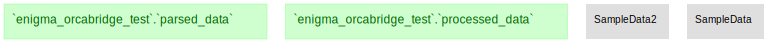

In [ ]:
dj.Diagram(schema)